In [1]:
%matplotlib inline

import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da

In [2]:
def gen_portfolio_allocations(symbols, resolution):
    alloc_values = np.arange(0., 1.+resolution, resolution)
    alloc_combinations = list(itertools.product(alloc_values, repeat=len(symbols)))
    alloc_combinations = pd.DataFrame(alloc_combinations, columns=symbols)
    return alloc_combinations[alloc_combinations.sum(1) == 1]

In [3]:
def simulate_portfolio(start_date, end_date, symbols, allocation):
    timeofday = dt.timedelta(hours=16)
    timestamps = du.getNYSEdays(start_date, end_date, timeofday)
    
    dataobject = da.DataAccess('Yahoo')
    keys = ['actual_close', 'close']
    data = dataobject.get_data(timestamps, symbols, keys)
    data_frame = dict(zip(keys, data))
    close_prices = data_frame['close'].values
    normalized_close_prices = close_prices / close_prices[0, :]
    
    daily_returns = normalized_close_prices.copy()
    tsu.returnize0(daily_returns)
    
    portfolio_returns = np.sum(daily_returns * allocation, axis=1)
    portfolio_total = np.cumprod(portfolio_returns + 1)  # cumulative returns
    component_total = np.cumprod(daily_returns + 1, axis=0)
     
    average_portfolio_daily_returns = portfolio_returns.mean()
    # use sample std dev ddof=1, divide by N-1
    portfolio_daily_returns_std_dev = portfolio_returns.std(ddof=1)
    sharpe_ratio = np.sqrt(250) * (average_portfolio_daily_returns/portfolio_daily_returns_std_dev)
    
    plt.clf()
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(timestamps, component_total, alpha=0.3)
    plt.plot(timestamps, portfolio_total)
    names = symbols
    names.append('Portfolio')
    plt.legend(names)
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    fig.autofmt_xdate(rotation=45)
    return {
        'avg-daily-returns': average_portfolio_daily_returns,
        'portfolio-volatility': portfolio_daily_returns_std_dev,
        'sharpe-ratio': sharpe_ratio,
        'portfolio-cumulative-returns': portfolio_returns.sum(),
        'portfolio-total': portfolio_total,
    }

In [4]:
start_date = dt.datetime(2011, 1, 1)
end_date = dt.datetime(2011, 12, 31)
symbols = ['AAPL', 'GLD', 'GOOG', 'XOM']
allocation = [0.4, 0.4, 0.0, 0.2]

In [5]:
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2010, 12, 31)
symbols = ['AXP', 'HPQ', 'IBM', 'HNZ']
allocation = [0.0, 0.0, 0.0, 1.0]

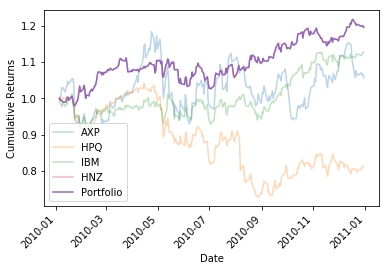

In [6]:
result = simulate_portfolio(start_date, end_date, symbols, allocation)

In [7]:
(result['portfolio-total'] - 1).sum()

24.875607883286268